# Dynamic Model Averaging (DMA) Application for Germany
This notebook is supposed to bundle the parts for DMA application to Germany and produce the analysis used in the final paper.
It is structured as follows:
1. Present Data
2. Present Factor Analysis results
3. Find optimal parameters
4. Show DMA Output
   1. Inclusion Probabilities
   2. Expected number of predictors
   3. Forecast performance
5. Use different weighting on prefered specification

In [32]:
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path
import pickle
import pandas as pd
import numpy as np
import itertools
import random
import plotly
import plotly.express as px
import scipy.stats as stats
import matplotlib.pyplot as plt
from factor_analyzer.factor_analyzer import FactorAnalyzer
from statsmodels.regression.linear_model import OLS

from src.data import import_data
from src.data.data_class import Data
from src.models.preliminaries import Settings
from src.models.dma import DMA
from src.models.tvp import TVP
from src.models import dm_test


from helper_scripts import variable_groups

from statsmodels.tsa import seasonal

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# # how to save sth
# %%capture cap --no-stderr
# with open(os.path.join(output_path, 'test.pkl'), 'wb') as f:
#     pickle.dump(cap, f)
# with open(os.path.join(output_path, 'test.pkl'), 'rb') as f:
#     cap = pickle.load(f)
# cap.show()

# Replication Settings

In [3]:
# specify which parts of the analysis to replicate
replicate = {'plot_data': False,         # replicate exploratory data analysis
                'load_plots': False,      # load saved plots
            'factor_analysis': True,       # produce FA results or simply load the resulting df
                'plot_fa_stats': True,
             'grid_search': False,      # first grid search to get an idea which are the best combinations
                'save_grid_results': True,
             'DMA_FA_selected': True,   # DMA with data from factor analysis on selected combinations
                'save_DMA_FA': True,    # save results
             'DMA_selected': False,      # DMA with normal on selected combinations - CAREFULL this takes a long time. So consider setting params.hlags = 0
                'save_DMA': False,    # save results
             'other_models': True,  # tvp and ar model
                'save_other_models': True,
            'preferred_models_analysis': True,
             'different_weightings_h1': False,
             'different_weightings_h4': False  # alternative weightings on prefered specification
                }
output_path = os.path.join(Path().cwd(), 'saved_outputs_4factors')
plotly.io.templates.default = "plotly_white"
plotly.io.renderers.default = 'png'

# Data
To recreate the dataset, run the following scripts in src.data:
1. "download_data.py": downloads data from the OECD database
2. "prepare_data.py": runs multiple steps to make the dataset ready for use
   1. transforms vintage data set into growth series (the transformation into growth series circumvents baseline and other changes in the methodology)
   2. combine dataset into one dataset that can be accessed as "data/processed/combined_data.csv"
   3. selects data specified in "data/processed/selected_data.csv"
   4. seasonally transforms the data (Season-Trend decomposition using LOESS - https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.STL.html#statsmodels.tsa.seasonal.STL)

In [4]:
data_path = os.path.join(Path().cwd().parent, 'data', 'processed')
# load seasonally adjusted dataset
with open(os.path.join(data_path, 'df_sa.pkl'), 'rb') as f:
    df_sa = pickle.load(f) # load raw data
# "selected_data.csv" contains information about variables names, abbreviations and the required type of transformation
selection = pd.read_csv(os.path.join(data_path, 'selected_data.csv'))
df_sa.describe()

var code,CPI_house_energy,PCI_energy_,HICP_energy,HICP_excl_energy,CPI,deflator_GDP,unemp,employment,GDP,cons_private,...,interest_rate_long,M3,M1,business_conf_manufacturing,business_conf_construct,business_conf_service,business_conf_retail,cons_conf_tendency,business_situation,residential_permits
count,123.000000,108.000000,104.000000,108.000000,123.000000,123.000000,123.000000,122.000000,123.000000,123.000000,...,123.000000,123.000000,123.000000,123.000000,123.000000,107.000000,123.000000,123.000000,123.000000,111.000000
mean,86.044251,87.012686,84.341505,92.755311,0.004721,0.004284,-0.003422,0.001091,0.002326,0.001503,...,3.463803,73.059570,65.051820,-6.727642,-21.869919,16.915888,-15.618699,99.946968,99.928214,29339.023758
std,14.225694,20.686686,20.142079,8.294870,0.004461,0.004434,0.033366,0.004588,0.011852,0.012954,...,2.511013,32.274109,43.145580,13.369695,20.970658,15.694436,10.782244,1.088837,1.342361,12214.439550
min,54.290421,54.877066,50.172049,79.809765,-0.006218,-0.004797,-0.096044,-0.010906,-0.078606,-0.092427,...,-0.604967,28.239989,16.992672,-42.200000,-55.700000,-22.000000,-41.200000,96.952924,95.408918,12903.224314
25%,73.991181,66.273204,65.311428,85.461263,0.002036,0.001382,-0.023105,-0.001753,-0.000176,-0.001626,...,1.381471,41.848292,27.878798,-15.400000,-42.450000,9.850000,-24.200000,99.334636,99.292014,20146.329471
50%,86.943304,93.195680,90.987561,91.996135,0.004041,0.003839,-0.006730,0.000564,0.003102,0.002517,...,3.829682,70.994604,56.696744,-6.100000,-23.000000,16.500000,-17.800000,99.964845,99.990484,25712.133386
75%,99.834497,103.481214,101.972046,99.628004,0.006383,0.005843,0.019722,0.003528,0.005931,0.005418,...,5.147533,93.580208,87.016878,0.800000,-7.150000,22.550000,-6.400000,100.702736,100.968382,37431.426816
max,109.463789,148.621775,115.784535,109.938300,0.019812,0.021539,0.101676,0.016532,0.047462,0.050932,...,8.387854,145.809700,178.189434,25.600000,20.900000,50.100000,13.500000,102.119658,102.336481,64217.291026


## Exploratory Data Analysis
Plot the data to get an overview over the data and its properties.

In [5]:
# load data with all variables and
params = Settings()                                 # init settings
params.h_fore = 1
params.miss_treatment = 3                           # no treatment for missing variables
params.plag = 4                                     # lag inflation to include later
params.use_x = selection['var code'].to_list()      # specify to use all variables
params.tcodesX = params.get_tcodesX(selection)      # get transformation codes
params.restricted_vars = ['intercept', 'CPI']       # these variables are in all models
params.first_sample_ends = '2004-12-31'             # start of calculation of statistics
# params.print_setting_options()                    # if parameter options should be shown
data = Data(df_sa, params)                          # creates an instance of the Data class that contains the transformed data
df_intercept_CPI = data.X.iloc[:,:(params.plag+params.intercept+1)] # the intercept and annualized CPI+lags are ordered at the beginning of the df - save df to attach it again later
df_sa_trans = data.X.iloc[:,(params.plag+params.intercept+1):]      # remove the vars

%run helper_scripts/variable_groups                 # get variable groups

In [6]:
if replicate['plot_data']:
    if not replicate['load_plots']:
        for g in var_groups:                                # plot variable groups
            df_temp = df_sa_trans[var_groups[g]]
            v_inds = [np.where(selection['var code'] == v)[0][0] for v in var_groups[g]]
            names = [selection['var code'][v]+': '+selection['Variable'][v] for v in v_inds]
            df_temp.columns = names
            fig = px.line(df_temp)
            fig.update_layout(
                        title=str(g),
                        title_x=0.5,
                        yaxis_title='',
                        xaxis_title='',
                        legend_title='Variables',
                        legend_orientation='v',
                        legend_y=0.95
                        )
            fig.show()
    else:
        with open(os.path.join(output_path, 'data_plots.pkl'), 'rb') as f:
            cap = pickle.load(f)
        cap.show()

# Factor Analysis
Do a Factor analysis to reduce the dimensionality of the data without loosing too much information.

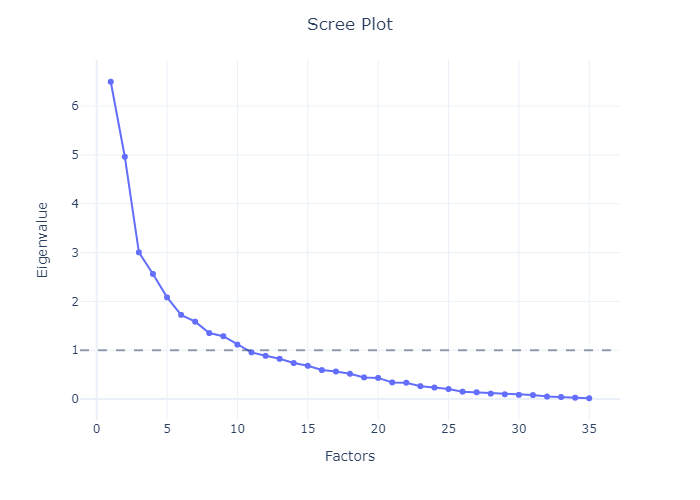

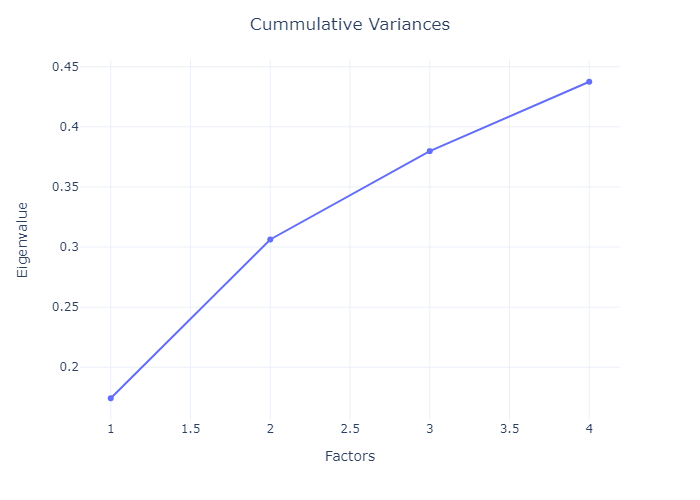

In [7]:

fa_lags = 3
# Instantiate factor analysis object
df_fa = df_sa_trans.drop(infl_vars, axis=1)
n_factors = 4
fa = FactorAnalyzer(n_factors=n_factors, rotation='oblimax')    # quartimax for orthogonal rotation, oblimax for oblique
fa.fit(df_fa)
ev, v = fa.get_eigenvalues()

# plots
if replicate['plot_fa_stats']:
    # Scree Plot
    fig = px.line(y=ev, x=range(1,df_fa.shape[1]+1), markers=True)
    fig.add_hline(y=1, line_dash='dash', opacity=0.5)
    fig.update_layout(
                    title='Scree Plot',
                    title_x=0.5,
                    yaxis_title='Eigenvalue',
                    xaxis_title='Factors'
                    )
    fig.show()
    # Cummulative Variances
    fa_var = fa.get_factor_variance()   # returns list with variance, proportional_variance and cumulative_variances
    fig = px.line(y=fa_var[2], x=range(1,n_factors+1), markers=True)
    fig.update_layout(
                    title='Cummulative Variances',
                    title_x=0.5,
                    yaxis_title='Eigenvalue',
                    xaxis_title='Factors'
                    )
    fig.show()

# Analysis
# calculate communalities
    # Note: for oblique rotation, the interpretation is different!
pd_communalities = pd.Series(fa.get_communalities(), index=df_fa.columns, name='Communality')
#print(pd_communalities)
# get factors
df_factors = pd.DataFrame(fa.transform(df_fa.fillna(0)), index = df_fa.index)
# rename columns
factor_cols = ['Factor_'+str(i) for i in list(df_factors.columns)]
df_factors.columns = factor_cols
# to see whether one should take the oblique rotation, one can look at the correlations in the factors. If they are heavily correlated, use the oblique rotation
# df_factors.corr()

# lag factors - This needs to be adjusted if you want more lags
    # The maximum that my PC is able to do with 5 factors is 2 lags
if fa_lags == 3:
    df_factors_with_lag = pd.concat((df_factors, df_factors.shift(1), df_factors.shift(2), df_factors.shift(3)), axis=1)
    factor_cols_lag1 = [i+'_t-1' for i in factor_cols]
    factor_cols_lag2 = [i+'_t-2' for i in factor_cols]
    factor_cols_lag3 = [i+'_t-3' for i in factor_cols]
    df_factors_with_lag.columns = factor_cols+factor_cols_lag1+factor_cols_lag2+factor_cols_lag3
    df_fa_post = pd.concat((df_intercept_CPI, df_factors_with_lag), axis=1)
    df_fa_post = df_fa_post.iloc[fa_lags:, :]
elif fa_lags == 1:
    df_factors_with_lag = pd.concat((df_factors, df_factors.shift(1)), axis=1)
    factor_cols_lag1 = [i+'_t-1' for i in factor_cols]
    df_factors_with_lag.columns = factor_cols+factor_cols_lag1
    df_fa_post = pd.concat((df_intercept_CPI, df_factors_with_lag), axis=1)
    df_fa_post = df_fa_post.iloc[2:, :]     # account for the lagging of the factors
# with open(os.path.join(output_path, 'df_fa_quartimax.pkl'), 'wb') as f:
#     pickle.dump(df_fa_post, f)
else:
    with open(os.path.join(output_path, 'df_fa_quartimax_f8.pkl'), 'rb') as f:
        df_fa_post = pickle.load(f)
# adjust data class for FA results
data.X = df_fa_post # can be deleted from here
data.T = data.X.shape[0]
data.N = data.X.shape[1]
data.y_dep = data.y_dep[fa_lags:] # adjust for lagging

In [8]:
df_fa_post

,intercept,CPI,CPI_t-1,CPI_t-2,CPI_t-3,CPI_t-4,Factor_0,Factor_1,Factor_2,Factor_3,...,Factor_2_t-1,Factor_3_t-1,Factor_0_t-2,Factor_1_t-2,Factor_2_t-2,Factor_3_t-2,Factor_0_t-3,Factor_1_t-3,Factor_2_t-3,Factor_3_t-3
1993-06-30,1,0.035956,0.079248,0.021642,0.034222,0.051887,-1.903985,1.522167,-0.609921,2.930290,...,-1.294031,3.781385,-2.524827,0.888292,-1.908944,1.748748,-2.186417,1.348561,-1.467944,2.791995
1993-09-30,1,0.034315,0.035956,0.079248,0.021642,0.034222,-1.299215,1.205313,-1.201279,2.508029,...,-0.609921,2.930290,-3.006296,0.834517,-1.294031,3.781385,-2.524827,0.888292,-1.908944,1.748748
1993-12-31,1,0.022549,0.034315,0.035956,0.079248,0.021642,-1.863369,1.186144,-0.652460,3.784763,...,-1.201279,2.508029,-1.903985,1.522167,-0.609921,2.930290,-3.006296,0.834517,-1.294031,3.781385
1994-03-31,1,0.024201,0.022549,0.034315,0.035956,0.079248,0.018275,1.391713,-1.107076,2.256730,...,-0.652460,3.784763,-1.299215,1.205313,-1.201279,2.508029,-1.903985,1.522167,-0.609921,2.930290
1994-06-30,1,0.027120,0.024201,0.022549,0.034315,0.035956,-0.967181,0.853036,-0.839421,3.981832,...,-1.107076,2.256730,-1.863369,1.186144,-0.652460,3.784763,-1.299215,1.205313,-1.201279,2.508029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31,1,0.015118,-0.010759,0.009828,-0.013438,0.006770,0.449129,-2.816119,0.648719,0.609716,...,1.947606,-1.613958,-3.314232,-3.503398,0.119058,2.743365,-1.750658,-1.810388,-1.568868,-0.804774
2021-03-31,1,0.051631,0.015118,-0.010759,0.009828,-0.013438,1.191871,-1.241219,1.235433,2.856059,...,0.648719,0.609716,2.545551,-1.355607,1.947606,-1.613958,-3.314232,-3.503398,0.119058,2.743365
2021-06-30,1,0.028673,0.051631,0.015118,-0.010759,0.009828,2.328719,-0.475561,-0.445933,0.315783,...,1.235433,2.856059,0.449129,-2.816119,0.648719,0.609716,2.545551,-1.355607,1.947606,-1.613958
2021-09-30,1,0.065886,0.028673,0.051631,0.015118,-0.010759,-0.638028,-1.678404,-1.842608,3.588040,...,-0.445933,0.315783,1.191871,-1.241219,1.235433,2.856059,0.449129,-2.816119,0.648719,0.609716


In [9]:
pd_communalities

CPI_house_energy               0.258028
PCI_energy_                    0.463563
HICP_energy                    0.499170
unemp                          0.484900
employment                     0.361230
GDP                            0.770072
cons_private                   0.370157
cons_gov                       0.140971
invest                         0.805516
earnings_hourly                0.030379
prod_ind                       0.603630
retail                         0.064681
prod_constr                    0.188275
trade_imp                      0.509362
trade_exp                      0.645739
infl_exp_current_year          0.814221
infl_exp_next_year             0.940354
infl_exp_2_year_ahead          0.847642
infl_exp_5_year_ahead          0.371917
dax                            0.212218
invest_private_no_housing      0.745870
invest_private_housing         0.331135
supply_index_global            0.117994
supply_index_eu                0.039519
interest_rate_short            0.627063


In [10]:
def get_r_quared_factors(factor, df_fa):
    rsquared = {}
    df_temp = pd.concat((factor, df_fa), axis=1).dropna()
    for name, values in df_temp.iloc[:,1:].iteritems():
        model = OLS(endog=df_temp.iloc[:,0], exog=values).fit()
        rsquared[name] = model.rsquared
    return pd.Series(rsquared, name=factor.name)

                # pred = ar_model.predict(X_test_lag)

In [12]:
pd_factor_rsqaured = pd.DataFrame(columns=df_factors.columns)
for name, values in df_factors.iteritems():
    pd_factor_rsqaured[name] = get_r_quared_factors(values, df_fa.iloc[3:, :])
# pd_factor_rsqaured
pd_factor_rsqaured_top = pd.DataFrame()
for name, values in pd_factor_rsqaured.iteritems():
    top5 = values.sort_values(ascending=False)[:5]
    pd_factor_rsqaured_top[name+'_vars'] = top5.index
    pd_factor_rsqaured_top[name+'_R2'] = top5.values
pd_factor_rsqaured_top

,Factor_0_vars,Factor_0_R2,Factor_1_vars,Factor_1_R2,Factor_2_vars,Factor_2_R2,Factor_3_vars,Factor_3_R2
0,GDP,0.632386,PCI_energy_,0.362506,business_situation,0.292092,HICP_energy,0.385593
1,invest,0.630860,CPI_house_energy,0.289443,employment,0.212301,PCI_energy_,0.317999
2,invest_private_no_housing,0.572672,interest_rate_short,0.268546,unemp,0.184986,trade_imp,0.149365
3,prod_ind,0.510048,HICP_energy,0.197962,trade_exp,0.172207,business_conf_manufacturing,0.143451
4,business_conf_manufacturing,0.374401,infl_exp_current_year,0.173966,business_conf_manufacturing,0.170063,invest_private_housing,0.127278


In [13]:
# print(pd_factor_rsqaured_top.to_latex())

In [14]:
print(df_factors.corr().round(2).to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  Factor\_0 &  Factor\_1 &  Factor\_2 &  Factor\_3 \\
\midrule
Factor\_0 &      1.00 &     -0.40 &      0.39 &     -0.54 \\
Factor\_1 &     -0.40 &      1.00 &     -0.60 &      0.49 \\
Factor\_2 &      0.39 &     -0.60 &      1.00 &     -0.44 \\
Factor\_3 &     -0.54 &      0.49 &     -0.44 &      1.00 \\
\bottomrule
\end{tabular}



In [15]:
# # pca
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# df_pca = StandardScaler().fit_transform(df_fa)
# df_pca = pd.DataFrame(df_pca)
# pca = PCA(n_components=5)
# principalComponents = pca.fit_transform(df_pca.fillna(0))
# pca.explained_variance_ratio_

# Sensitivity Analysis
Find optimal parameter settings for DMA by doing a grid search over the parameters $\lambda$ and  $\kappa$.

In [11]:
# specify settings for DMA
params.use_y = ['CPI']
params.print_settings()

The following preliminary settings are specified:
intercept : 1
plag : 4
hlag : 0
use_x : ['CPI_house_energy', 'PCI_energy_', 'HICP_energy', 'HICP_excl_energy', 'CPI', 'deflator_GDP', 'unemp', 'employment', 'GDP', 'cons_private', 'cons_gov', 'invest', 'earnings_hourly', 'prod_ind', 'retail', 'prod_constr', 'trade_imp', 'trade_exp', 'infl_exp_current_year', 'infl_exp_next_year', 'infl_exp_2_year_ahead', 'infl_exp_5_year_ahead', 'dax', 'invest_private_no_housing', 'invest_private_housing', 'supply_index_global', 'supply_index_eu', 'interest_rate_short', 'interest_rate_long', 'M3', 'M1', 'business_conf_manufacturing', 'business_conf_construct', 'business_conf_service', 'business_conf_retail', 'cons_conf_tendency', 'business_situation', 'residential_permits']
use_y : ['CPI']
tcodesX : [5, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 5, 5, 5, 5, 1, 2, 5, 5, 1, 1, 1, 1, 2, 2, 5]
tcodey : 1
miss_treatment : 3
lamda : 0.99
alpha : 0.9
kappa : 0.95
forgetting_method : 2
pri

In [12]:
def grid_search_a_l(params, data, grid):
    stats_fe = ['alpha', 'lambda', 'MAFE_DMA', 'MSFE_DMA', 'BIAS_DMA', 'MAFE_DMS', 'MSFE_DMS', 'BIAS_DMS']
    pd_stats = pd.DataFrame(columns=stats_fe)
    for g in grid:
        a = g[0]
        l = g[1]
        print(f'run dma for alpha = {a} and lambda = {l}')
        params.alpha = a
        params.lamda = l
        dma = DMA(params, data)
        dma.run_dma()
        dma.forecast_statistics(plot_fe=False, plot_y_fe=False, print_stats=False, unit='percent')
        stats_temp = [a, l, dma.MAFE_DMA, dma.MSFE_DMA, dma.BIAS_DMA, dma.MAFE_DMS, dma.MSFE_DMS, dma.BIAS_DMS]
        pd_stats.loc[str(g)] = stats_temp
    return pd_stats

In [13]:
if replicate['grid_search']:
    # do grid search on data with 4 factors to speed it up
    with open(os.path.join(output_path, 'df_fa_post_4_factors.pkl'), 'rb') as f:
        df_fa_post_4_factors = pickle.load(f)
    alpha_range = np.arange(0.93, 0.991, 0.02)
    lambdaa_range = np.arange(0.93, 0.991, 0.02)
    grid = np.transpose([np.tile(alpha_range, len(lambdaa_range)), np.repeat(lambdaa_range, len(alpha_range))])

    params.h_fore = 1
    data_fa_post_4_factors_h1 = Data(df_sa, params)
    data_fa_post_4_factors_h1.X = df_fa_post_4_factors
    data_fa_post_4_factors_h1.T = data_fa_post_4_factors_h1.X.shape[0]
    data_fa_post_4_factors_h1.N = data_fa_post_4_factors_h1.X.shape[1]
    data_h1 = Data(df_sa, params)
    data_fa_post_4_factors_h1.y_dep = data_h1.y_dep[2:]    # adjust for lagging
    params.h_fore = 4
    data_fa_post_4_factors_h4 = Data(df_sa, params)
    data_fa_post_4_factors_h4.X = df_fa_post_4_factors
    data_fa_post_4_factors_h4.T = data_fa_post_4_factors_h4.X.shape[0]
    data_fa_post_4_factors_h4.N = data_fa_post_4_factors_h4.X.shape[1]
    data_h4 = Data(df_sa, params)
    data_fa_post_4_factors_h4.y_dep = data_h4.y_dep[2:]    # adjust for lagging

    pd_stats_1 = grid_search_a_l(params, data_fa_post_4_factors_h1, grid)
    pd_stats_4 = grid_search_a_l(params, data_fa_post_4_factors_h4, grid)
    if replicate['save_grid_results']:
        with open(os.path.join(output_path, 'pd_stats_1.pkl'), 'wb') as f:
            pickle.dump(pd_stats_1, f)
        with open(os.path.join(output_path, 'pd_stats_4.pkl'), 'wb') as f:
            pickle.dump(pd_stats_4, f)
else:   # the saved results are produced using a dataset produced by factor analysis with the quartimax rotation, 4 factors and two lags of those factors
    with open(os.path.join(output_path, 'pd_stats_1.pkl'), 'rb') as f:
        pd_stats_1 = pickle.load(f)
    with open(os.path.join(output_path, 'pd_stats_4.pkl'), 'rb') as f:
        pd_stats_4 = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\yanni\\Google Drive\\Uni\\Master\\Financial Econometrics Seminar\\DMA-Application-FinEcon\\notebooks\\saved_outputs_4factors\\pd_stats_1.pkl'

In [14]:
# results for forecast horizon: 1 quarter
pd_stats_1

NameError: name 'pd_stats_1' is not defined

In [15]:
# results for forecast horizon: 4 quarters
pd_stats_4

NameError: name 'pd_stats_4' is not defined

# DMA on different specifications
Specifications to test:
1. DMA with F.A. reduced dataset and different $\alpha$ and $\lambda$ combinations
2. DMA with some standard predictors
For
- ($\alpha$, $\lambda$) = (0.99, 0.99)
- ($\alpha$, $\lambda$) = (0.97, 0.99)
- ($\alpha$, $\lambda$) = (0.97, 0.97)
- ($\alpha$, $\lambda$) = (0.95, 0.95)
3. Simple TVP model
4. Simple AR model

Do everything for h = 1 and h = 4

In [16]:
def DMA_steps(params, data, alpha, lamda, save, name, output_path):
    params.alpha = alpha
    params.lamda = lamda
    print(f'(alpha, lambda) = ({alpha}, {lamda})')
    dma = DMA(params, data)
    dma.run_dma()
    dma.forecast_statistics(unit='percent', plot_fe=False, plot_y_fe=False, print_stats=False)
    stats_temp = [params.alpha, params.lamda,
                     dma.MAFE_DMA, dma.MSFE_DMA, dma.BIAS_DMA,
                     dma.MAFE_DMS, dma.MSFE_DMS, dma.BIAS_DMS]
    if save:
        with open(os.path.join(output_path, name+'.pkl'), 'wb') as f:
                pickle.dump(dma, f)
    return dma, stats_temp
def get_stats(dma):
    dma.forecast_statistics(unit='percent', plot_fe=False, plot_y_fe=False, print_stats=False)
    stats_temp = [params.alpha, params.lamda,
                     dma.MAFE_DMA, dma.MSFE_DMA, dma.BIAS_DMA,
                     dma.MAFE_DMS, dma.MSFE_DMS, dma.BIAS_DMS]
    return stats_temp

## DMA with Factor Analysis data

In [17]:
# settings for FA DMA
# with open(os.path.join(output_path, 'df_fa_oblimax.pkl'), 'rb') as f:
#         df_fa_post = pickle.load(f)
# adjust data class for FA results

params.h_fore = 1
data_fa_h1 = Data(df_sa, params)
data_fa_h1.X = df_fa_post
data_fa_h1.T = data.X.shape[0]
data_fa_h1.N = data.X.shape[1]
data_h1 = Data(df_sa, params)
data_fa_h1.y_dep = data_h1.y_dep[fa_lags:]    # adjust for lagging
params.h_fore = 4
data_fa_h4 = Data(df_sa, params)
data_fa_h4.X = df_fa_post
data_fa_h4.T = data.X.shape[0]
data_fa_h4.N = data.X.shape[1]
data_h4 = Data(df_sa, params)
data_fa_h4.y_dep = data_h4.y_dep[fa_lags:]    # adjust for lagging

stats_fe = ['alpha', 'lambda', 'MAFE_DMA', 'MSFE_DMA', 'BIAS_DMA', 'MAFE_DMS', 'MSFE_DMS', 'BIAS_DMS']

In [20]:
if replicate['DMA_FA_selected']:
    save = replicate['save_DMA_FA']
    params.h_fore=1
    data = data_fa_h1
    # (0.99, 0.99)
    dma_fa_h1_1, stats_fa_h1_1 = DMA_steps(params, data, 0.99, 0.99, save, 'dma_fa_h1_1', output_path)
    # (0.99, 0.97)
    dma_fa_h1_2, stats_fa_h1_2 = DMA_steps(params, data, 0.97, 0.97, save, 'dma_fa_h1_2', output_path)
    # (0.97, 0.97)
    dma_fa_h1_3, stats_fa_h1_3 = DMA_steps(params, data, 0.95, 0.95, save, 'dma_fa_h1_3', output_path)
    # (0.97, 0.95)
    # dma_fa_h1_4, stats_fa_h1_4 = DMA_steps(params, data, 0.93, 0.97, save, 'dma_fa_h1_4', output_path)
else:
    with open(os.path.join(output_path, 'dma_fa_h1_1.pkl'), 'rb') as f:
        dma_fa_h1_1 = pickle.load(f)
    stats_fa_h1_1 = get_stats(dma_fa_h1_1)
    with open(os.path.join(output_path, 'dma_fa_h1_2.pkl'), 'rb') as f:
        dma_fa_h1_2 = pickle.load(f)
    stats_fa_h1_2 = get_stats(dma_fa_h1_2)
    with open(os.path.join(output_path, 'dma_fa_h1_3.pkl'), 'rb') as f:
        dma_fa_h1_3 = pickle.load(f)
    stats_fa_h1_3 = get_stats(dma_fa_h1_3)
    # with open(os.path.join(output_path, 'dma_fa_h1_4.pkl'), 'rb') as f:
    #     dma_fa_h1_4 = pickle.load(f)
    # stats_fa_h1_4 = get_stats(dma_fa_h1_4)

(alpha, lambda) = (0.99, 0.99)


100%|██████████| 114/114 [14:12<00:00,  7.48s/it]


DMA finished
(alpha, lambda) = (0.97, 0.97)


100%|██████████| 114/114 [09:30<00:00,  5.01s/it]


DMA finished
(alpha, lambda) = (0.95, 0.95)


100%|██████████| 114/114 [07:52<00:00,  4.14s/it]


DMA finished


In [22]:
if replicate['DMA_FA_selected']:
    save = replicate['save_DMA_FA']
    params.h_fore=4
    data = data_fa_h4
    # (0.99, 0.99)
    dma_fa_h4_1, stats_fa_h4_1 = DMA_steps(params, data, 0.99, 0.99, save, 'dma_fa_h4_1', output_path)
    # (0.99, 0.97)
    dma_fa_h4_2, stats_fa_h4_2 = DMA_steps(params, data, 0.97, 0.97, save, 'dma_fa_h4_2', output_path)
    # (0.97, 0.97)
    dma_fa_h4_3, stats_fa_h4_3 = DMA_steps(params, data, 0.95, 0.95, save, 'dma_fa_h4_3', output_path)
    # (0.97, 0.95)
    # dma_fa_h4_4, stats_fa_h4_4 = DMA_steps(params, data, 0.93, 0.97, save, 'dma_fa_h4_4', output_path)
else:
    with open(os.path.join(output_path, 'dma_fa_h4_1.pkl'), 'rb') as f:
        dma_fa_h4_1 = pickle.load(f)
    stats_fa_h4_1 = get_stats(dma_fa_h4_1)
    with open(os.path.join(output_path, 'dma_fa_h4_2.pkl'), 'rb') as f:
        dma_fa_h4_2 = pickle.load(f)
    stats_fa_h4_2 = get_stats(dma_fa_h4_2)
    with open(os.path.join(output_path, 'dma_fa_h4_3.pkl'), 'rb') as f:
        dma_fa_h4_3 = pickle.load(f)
    stats_fa_h4_3 = get_stats(dma_fa_h4_3)
    # with open(os.path.join(output_path, 'dma_fa_h4_4.pkl'), 'rb') as f:
    #     dma_fa_h4_4 = pickle.load(f)
    # stats_fa_h4_4 = get_stats(dma_fa_h4_4)

(alpha, lambda) = (0.99, 0.99)


100%|██████████| 111/111 [08:31<00:00,  4.61s/it]


DMA finished
(alpha, lambda) = (0.97, 0.97)


100%|██████████| 111/111 [08:12<00:00,  4.43s/it]


DMA finished
(alpha, lambda) = (0.95, 0.95)


100%|██████████| 111/111 [08:53<00:00,  4.81s/it]


DMA finished


## DMA with standard data

In [ ]:
params.use_x = ['unemp',    # or employment
                'GDP',
                'prod_ind', # or prod_constr (might be better for h=4)
                'interest_rate_short',
                'interest_rate_long',
                'dax',
                'M3',
                'infl_exp_current_year',    # or infl_exp_next_year, infl_exp_2_year_ahead
                # 'trade_exp',
                'CPI_house_energy',  # or PCI_energy_ or HICP_energy
                'supply_index_global',  # or 'supply_index_eu'
                'business_conf_manufacturing'
                ]
params.miss_treatment = 1
params.hlag = 1 # this makes it run super slow!
params.tcodesX = params.get_tcodesX(selection)
params.h_fore=1
data_h1 = Data(df_sa, params)
params.h_fore=4
data_h4 = Data(df_sa, params)

In [ ]:
if replicate['DMA_selected']:
    save = replicate['save_DMA']
    params.h_fore=1
    data = data_h1
    # (0.99, 0.99)
    dma_h1_1, stats_h1_1 = DMA_steps(params, data, 0.99, 0.99, save, 'dma_h1_1', output_path)
    # (0.99, 0.97)
    dma_h1_2, stats_h1_2 = DMA_steps(params, data, 0.97, 0.99, save, 'dma_h1_2', output_path)
    # (0.97, 0.97)
    dma_h1_3, stats_h1_3 = DMA_steps(params, data, 0.97, 0.97, save, 'dma_h1_3', output_path)
    # (0.97, 0.95)
    dma_h1_4, stats_h1_4 = DMA_steps(params, data, 0.95, 0.95, save, 'dma_h1_4', output_path)

In [ ]:
if replicate['DMA_selected']:
    save = replicate['save_DMA']
    params.h_fore=4
    data = data_h4
    # (0.99, 0.99)
    dma_h4_1, stats_h4_1 = DMA_steps(params, data, 0.99, 0.99, save, 'dma_h4_1', output_path)
    # (0.99, 0.97)
    dma_h4_2, stats_h4_2 = DMA_steps(params, data, 0.97, 0.97, save, 'dma_h4_2', output_path)
    # (0.97, 0.97)
    dma_h4_3, stats_h4_3 = DMA_steps(params, data, 0.93, 0.97, save, 'dma_h4_3', output_path)
    # (0.97, 0.95)
    dma_h4_4, stats_h4_4 = DMA_steps(params, data, 0.95, 0.95, save, 'dma_h4_4', output_path)

## On simple TVP

In [23]:
if replicate['other_models']:
    params.h_fore = 1
    tvp_h1 = TVP(params, data_fa_h1)
    tvp_h1.fit()
    tvp_h1.forecast_statistics(unit='percent',print_stats=False)
    stats_TVP_h1 = [tvp_h1.MAFE, tvp_h1.MSFE, tvp_h1.BIAS]

    params.h_fore = 4
    #data = Data(data_fa_h4, params)
    tvp_h4 = TVP(params, data_fa_h4)
    tvp_h4.fit()
    tvp_h4.forecast_statistics(unit='percent',print_stats=False)
    stats_TVP_h4 = [tvp_h4.MAFE, tvp_h4.MSFE, tvp_h4.BIAS]
    if replicate['save_other_models']:
        with open(os.path.join(output_path, 'tvp_h1.pkl'), 'wb') as f:
                pickle.dump(tvp_h1, f)
        with open(os.path.join(output_path, 'stats_TVP_h1.pkl'), 'wb') as f:
                pickle.dump(stats_TVP_h1, f)
        with open(os.path.join(output_path, 'tvp_h4.pkl'), 'wb') as f:
                pickle.dump(tvp_h4, f)
        with open(os.path.join(output_path, 'stats_TVP_h4.pkl'), 'wb') as f:
                pickle.dump(stats_TVP_h4, f)
else:
    with open(os.path.join(output_path, 'tvp_h1.pkl'), 'rb') as f:
        tvp_h1 = pickle.load(f)
    with open(os.path.join(output_path, 'stats_TVP_h1.pkl'), 'rb') as f:
        stats_TVP_h1 = pickle.load(f)
    with open(os.path.join(output_path, 'tvp_h4.pkl'), 'rb') as f:
        tvp_h4 = pickle.load(f)
    with open(os.path.join(output_path, 'stats_TVP_h4.pkl'), 'rb') as f:
        stats_TVP_h4 = pickle.load(f)

## On AR(p)

In [24]:
if replicate['other_models']:
    params.lamda = 1
    params.use_x = None
    params.h_fore = 1
    data_ar_h1 = Data(df_sa, params)
    ar_h1 = TVP(params, data_ar_h1)
    ar_h1.fit()
    ar_h1.forecast_statistics(unit='percent', print_stats=False)
    stats_AR_h1 = [ar_h1.MAFE, ar_h1.MSFE, ar_h1.BIAS]

    params.h_fore = 4
    data_ar_h4 = Data(df_sa, params)
    ar_h4 = TVP(params, data_ar_h4)
    ar_h4.fit()
    ar_h4.forecast_statistics(unit='percent', print_stats=False)
    stats_AR_h4 = [ar_h4.MAFE, ar_h4.MSFE, ar_h4.BIAS]
    if replicate['save_other_models']:
        with open(os.path.join(output_path, 'ar_h1.pkl'), 'wb') as f:
                pickle.dump(ar_h1, f)
        with open(os.path.join(output_path, 'stats_AR_h1.pkl'), 'wb') as f:
                pickle.dump(stats_AR_h1, f)
        with open(os.path.join(output_path, 'ar_h4.pkl'), 'wb') as f:
                pickle.dump(ar_h4, f)
        with open(os.path.join(output_path, 'stats_AR_h4.pkl'), 'wb') as f:
                pickle.dump(stats_AR_h4, f)
else:
    with open(os.path.join(output_path, 'ar_h1.pkl'), 'rb') as f:
        ar_h1 = pickle.load(f)
    with open(os.path.join(output_path, 'stats_AR_h1.pkl'), 'rb') as f:
        stats_AR_h1 = pickle.load(f)
    with open(os.path.join(output_path, 'ar_h4.pkl'), 'rb') as f:
        ar_h4 = pickle.load(f)
    with open(os.path.join(output_path, 'stats_AR_h4.pkl'), 'rb') as f:
        stats_AR_h4 = pickle.load(f)

## TVP AR(p)

In [25]:
if replicate['other_models']:
    params.lamda = 0.99
    params.use_x = None
    params.h_fore = 1
    data_ar_h1 = Data(df_sa, params)
    ar_h1_tvp = TVP(params, data_ar_h1)
    ar_h1_tvp.fit()
    ar_h1_tvp.forecast_statistics(unit='percent', print_stats=False)
    stats_AR_tvp_h1 = [ar_h1_tvp.MAFE, ar_h1_tvp.MSFE, ar_h1_tvp.BIAS]

    params.h_fore = 4
    data_ar_h4 = Data(df_sa, params)
    ar_h4_tvp = TVP(params, data_ar_h4)
    ar_h4_tvp.fit()
    ar_h4_tvp.forecast_statistics(unit='percent', print_stats=False)
    stats_AR_tvp_h4 = [ar_h4_tvp.MAFE, ar_h4_tvp.MSFE, ar_h4_tvp.BIAS]
    if replicate['save_other_models']:
        with open(os.path.join(output_path, 'ar_h1_tvp.pkl'), 'wb') as f:
                pickle.dump(ar_h1_tvp, f)
        with open(os.path.join(output_path, 'stats_AR_tvp_h1.pkl'), 'wb') as f:
                pickle.dump(stats_AR_tvp_h1, f)
        with open(os.path.join(output_path, 'ar_h4_tvp.pkl'), 'wb') as f:
                pickle.dump(ar_h4_tvp, f)
        with open(os.path.join(output_path, 'stats_AR_tvp_h4.pkl'), 'wb') as f:
                pickle.dump(stats_AR_tvp_h4, f)
else:
    with open(os.path.join(output_path, 'ar_h1_tvp.pkl'), 'rb') as f:
        ar_h1_tvp = pickle.load(f)
    with open(os.path.join(output_path, 'stats_AR_tvp_h1.pkl'), 'rb') as f:
        stats_AR_tvp_h1 = pickle.load(f)
    with open(os.path.join(output_path, 'ar_h4_tvp.pkl'), 'rb') as f:
        ar_h4_tvp = pickle.load(f)
    with open(os.path.join(output_path, 'stats_AR_tvp_h4.pkl'), 'rb') as f:
        stats_AR_tvp_h4 = pickle.load(f)

## Combine stats

In [30]:
stats2 = ['MAFE', 'MSFE', 'BIAS']
stats_pd_all_h1 = pd.DataFrame.from_dict(data={'DMA F.A., h=1, (0.99, 0.99)': stats_fa_h1_1[2:5],
                                            'DMA F.A., h=1, (0.97, 0.97)': stats_fa_h1_2[2:5],
                                            'DMA F.A., h=1, (0.95, 0.95)': stats_fa_h1_3[2:5],
                                            #'DMA F.A., h=1, (0.95, 0.95)': stats_fa_h1_4[2:5],
                                            # 'DMA, h=1, (0.99, 0.99)': stats_h1_1[2:5],
                                            # 'DMA, h=1, (0.97, 0.99)': stats_h1_2[2:5],
                                            # 'DMA, h=1, (0.97, 0.97)': stats_h1_3[2:5],
                                            # 'DMA, h=1, (0.95, 0.95)': stats_h1_4[2:5],
                                            'DMS F.A., h=1, (0.99, 0.99)': stats_fa_h1_1[5:],
                                            'DMS F.A., h=1, (0.97, 0.97)': stats_fa_h1_2[5:],
                                            'DMS F.A., h=1, (0.95, 0.95)': stats_fa_h1_3[5:],
                                            # 'DMS F.A., h=1, (0.95, 0.95)': stats_fa_h1_4[5:],
                                            # 'DMS, h=1, (0.99, 0.99)': stats_h1_1[5:],
                                            # 'DMS, h=1, (0.97, 0.99)': stats_h1_2[5:],
                                            # 'DMS, h=1, (0.97, 0.97)': stats_h1_3[5:],
                                            # 'DMS, h=1, (0.95, 0.95)': stats_h1_4[5:]
                                            'TVP, h=1': stats_TVP_h1,
                                            'AR, h=1': stats_AR_h1,
                                            'AR TVP, h=1': stats_AR_tvp_h4
                                               },
                                orient='index',
                                columns=stats2)
stats_pd_all_h1*[100, 100**2, 100]

,MAFE,MSFE,BIAS
"DMA F.A., h=1, (0.99, 0.99)",0.601341,1.230434,0.065029
"DMA F.A., h=1, (0.97, 0.97)",0.607765,1.206556,0.067110
"DMA F.A., h=1, (0.95, 0.95)",0.639111,1.292632,0.059327
"DMS F.A., h=1, (0.99, 0.99)",0.600913,1.263688,0.062938
"DMS F.A., h=1, (0.97, 0.97)",0.602422,1.260812,0.054572
"DMS F.A., h=1, (0.95, 0.95)",0.624716,1.413657,0.037639
"TVP, h=1",0.780858,2.264239,0.047687
"AR, h=1",0.620791,1.362474,0.067935
"AR TVP, h=1",0.482953,0.691089,0.021517


In [27]:
stats_pd_all_h4 = pd.DataFrame.from_dict(data={'DMA F.A., h=4, (0.99, 0.99)': stats_fa_h4_1[2:5],
                                            'DMA F.A., h=4, (0.97, 0.97)': stats_fa_h4_2[2:5],
                                            'DMA F.A., h=4, (0.95, 0.95)': stats_fa_h4_3[2:5],
                                            # 'DMA F.A., h=4, (0.95, 0.95)': stats_fa_h4_4[2:5],
                                            # 'DMA, h=4, (0.99, 0.99)': stats_h4_1[2:5],
                                            # 'DMA, h=4, (0.97, 0.99)': stats_h4_2[2:5],
                                            # 'DMA, h=4, (0.97, 0.97)': stats_h4_3[2:5],
                                            # 'DMA, h=4, (0.95, 0.95)': stats_h4_4[2:5],
                                            'DMS F.A., h=4, (0.99, 0.99)': stats_fa_h4_1[5:],
                                            'DMS F.A., h=4, (0.97, 0.97)': stats_fa_h4_2[5:],
                                            'DMS F.A., h=4, (0.95, 0.95)': stats_fa_h4_3[5:],
                                            # 'DMS F.A., h=4, (0.95, 0.95)': stats_fa_h4_4[5:],
                                            # 'DMS, h=4, (0.99, 0.99)': stats_h4_1[5:],
                                            # 'DMS, h=4, (0.97, 0.99)': stats_h4_2[5:],
                                            # 'DMS, h=4, (0.97, 0.97)': stats_h4_3[5:],
                                            # 'DMS, h=4, (0.95, 0.95)': stats_h4_4[5:],
                                            'TVP, h=4': stats_TVP_h4,
                                            'AR, h=4': stats_AR_h4,
                                            'AR TVP, h=4': stats_AR_tvp_h4
                                               },
                                orient='index',
                                columns=stats2)
stats_pd_all_h4*[100, 100**2, 100]

,MAFE,MSFE,BIAS
"DMA F.A., h=4, (0.99, 0.99)",0.474190,0.696883,0.008257
"DMA F.A., h=4, (0.97, 0.97)",0.494251,0.793246,0.007700
"DMA F.A., h=4, (0.95, 0.95)",0.513911,0.848003,0.007782
"DMS F.A., h=4, (0.99, 0.99)",0.474825,0.682639,0.012590
"DMS F.A., h=4, (0.97, 0.97)",0.497838,0.787774,0.010458
"DMS F.A., h=4, (0.95, 0.95)",0.514119,0.844381,0.005679
"TVP, h=4",0.651608,1.276495,-0.099350
"AR, h=4",0.472692,0.673920,0.020749
"AR TVP, h=4",0.482953,0.691089,0.021517


In [1]:
actual_vals = dma_fa_h4_1.y_dep[dma_fa_h4_1.first_sample_ends:].tolist()
prediction_dma = dma_fa_h4_1.y_t_DMA[dma_fa_h4_1.first_sample_ends:].tolist()
prediction_ar = ar_h1.y_tvp[ar_h1.first_sample_ends:]
dm_test.dm_test(actual_vals, prediction_dma, prediction_ar, crit='MAD', h=1)

NameError: name 'dma_fa_h4_1' is not defined

In [31]:
stats_pd_all_h1_ind = [i.replace(', h=1', '') for i in stats_pd_all_h1.index]
stats_pd_all_h1_ind = [i.replace(' F.A.', '') for i in stats_pd_all_h1_ind]
stats_pd_all_h1_temp = stats_pd_all_h1.copy()
stats_pd_all_h1_temp.index = stats_pd_all_h1_ind
stats_pd_all_h1_temp.columns = stats_pd_all_h1_temp.columns+'_h=1'

stats_pd_all_h4_ind = [i.replace(', h=4', '') for i in stats_pd_all_h4.index]
stats_pd_all_h4_ind = [i.replace(' F.A.', '') for i in stats_pd_all_h4_ind]
stats_pd_all_h4_temp = stats_pd_all_h4.copy()
stats_pd_all_h4_temp.index = stats_pd_all_h4_ind
stats_pd_all_h4_temp.columns = stats_pd_all_h4_temp.columns+'_h=4'

stats_pd_all = pd.concat((stats_pd_all_h1_temp, stats_pd_all_h4_temp), axis=1)
print((stats_pd_all[['MAFE_h=1', 'MSFE_h=1', 'MAFE_h=4', 'MSFE_h=4']]*[100, 100**2, 100, 100**2]).to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  MAFE\_h=1 &  MSFE\_h=1 &  MAFE\_h=4 &  MSFE\_h=4 \\
\midrule
DMA, (0.99, 0.99) &  0.601341 &  1.230434 &  0.474190 &  0.696883 \\
DMA, (0.97, 0.97) &  0.607765 &  1.206556 &  0.494251 &  0.793246 \\
DMA, (0.95, 0.95) &  0.639111 &  1.292632 &  0.513911 &  0.848003 \\
DMS, (0.99, 0.99) &  0.600913 &  1.263688 &  0.474825 &  0.682639 \\
DMS, (0.97, 0.97) &  0.602422 &  1.260812 &  0.497838 &  0.787774 \\
DMS, (0.95, 0.95) &  0.624716 &  1.413657 &  0.514119 &  0.844381 \\
TVP               &  0.780858 &  2.264239 &  0.651608 &  1.276495 \\
AR                &  0.620791 &  1.362474 &  0.472692 &  0.673920 \\
AR TVP            &  0.482953 &  0.691089 &  0.482953 &  0.691089 \\
\bottomrule
\end{tabular}



# DMA Output on prefered specifications
   1. Inclusion Probabilities
   2. Expected number of predictors
   3. Forecast performance

## h = 1

In [ ]:
y_preds = pd.concat((dma_fa_h1_1.y_dep,
                     dma_fa_h1_1.y_t_DMA,
                     dma_fa_h1_1.y_t_DMS,
                     ar_h1_tvp.y_tvp[1:]), axis=1)*100
y_preds = y_preds.loc[dma_fa_h4_1.first_sample_ends:, :]
y_preds.columns = [r'$y_t$',
                r'$\hat{y}_t^{DMA - (0.99, 0.99)}$',
                r'$\hat{y}_t^{DMS - (0.99, 0.99)}$',
                r'$y_t^{AR TVP}$']
fig = px.line(y_preds,
              x=y_preds.index,
              y=y_preds.columns)
fig.update_layout(
    title="",
    title_x=0.5,
    yaxis_title='Inflation (in %)',
    xaxis_title='',
    legend_title="",
    margin_b=10,
    margin_t=10,
    legend_orientation='v',
    legend_y=0.95
    )
fig.show()

In [ ]:
if replicate['preferred_models_analysis']:
    fig = dma_fa_h1_1.forecast_statistics(unit='percent', plot_y_fe=True, return_fig=True, print_stats=False)
    fig.show()
    # plot inclusion probabilities
    fig = dma_fa_h1_1.plot_inclusion_prob(seperate_plots=False, return_fig=True)
    fig.show()
    # plot E[size]
    fig = dma_fa_h1_1.calc_E_size(out='plot', return_fig=True)
    fig.show()

    # show how important the model without extra factors is
    # find index of model that contains only the restricted variables
    z = [1 if np.array_equal(m, np.array([0,1,2,3,4,5])) else 0 for m in dma_fa_h1_1.models]
    ind = np.nonzero(z)
    inc_prob_ar = dma_fa_h1_1.prob_update[:, ind].flatten()
    print(f'Inclusion probability for AR(p) model: mean {inc_prob_ar.mean()} - median {np.median(inc_prob_ar)}')

## h=4

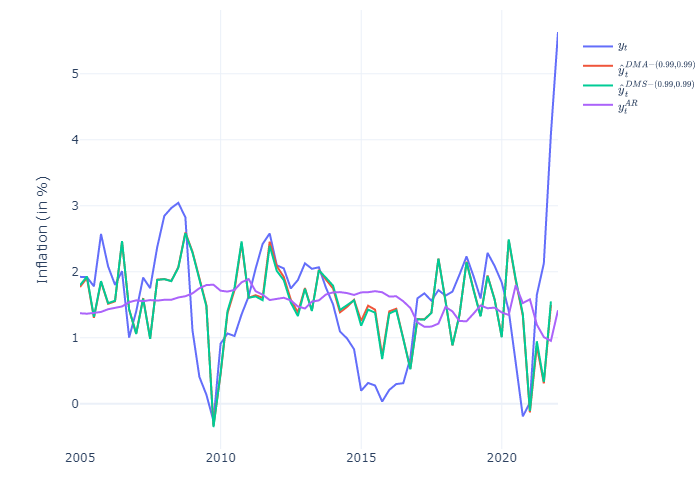

In [28]:
y_preds = pd.concat((dma_fa_h4_1.y_dep,
                     dma_fa_h4_1.y_t_DMA,
                     dma_fa_h4_1.y_t_DMS,
                     ar_h4.y_tvp), axis=1)*100
y_preds = y_preds[dma_fa_h4_1.first_sample_ends:]
y_preds.columns = [r'$y_t$',
                r'$\hat{y}_t^{DMA - (0.99, 0.99)}$',
                r'$\hat{y}_t^{DMS - (0.99, 0.99)}$',
                r'$y_t^{AR}$']
fig = px.line(y_preds,
              x=y_preds.index,
              y=y_preds.columns)
fig.update_layout(
    title="",
    title_x=0.5,
    yaxis_title='Inflation (in %)',
    xaxis_title='',
    legend_title="",
    margin_b=10,
    margin_t=10,
    legend_orientation='v',
    legend_y=0.95
    )
fig.show()

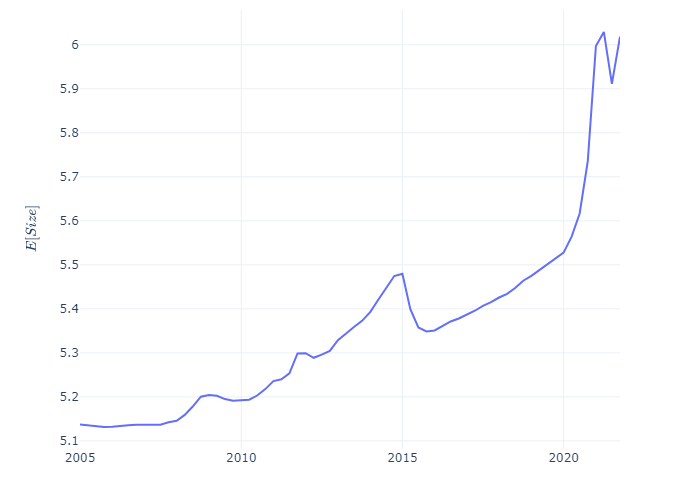

In [29]:
dma_fa_h4_1.calc_E_size(out='plot', return_fig=True)
first_sample_ends = dma_fa_h4_1.first_sample_ends
exp_size = dma_fa_h4_1.exp_size
n = np.where(exp_size.index == first_sample_ends)[0][0]
fig = px.line(x=exp_size.index[n:], y=exp_size[n:]-1,
                          title='Average number of predictors used in DMA')
fig.update_layout(
    title="",
    title_x=0.5,
    yaxis_title=r'$E[Size]$',
    xaxis_title='',
    legend_title="",
    margin_b=10,
    margin_t=10
)

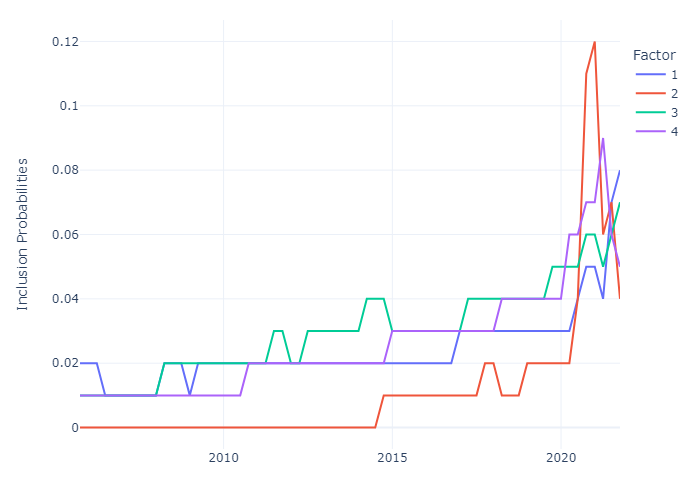

Inclusion probability for AR(p) model: mean 0.6996705863519069 - median 0.70899608361024


In [31]:
if replicate['preferred_models_analysis']:
    # fig = dma_fa_h4_1.forecast_statistics(unit='percent', plot_y_fe=True, return_fig=True, print_stats=False)
    # fig.show()
    # plot inclusion probabilities
    fig = dma_fa_h4_1.plot_inclusion_prob(seperate_plots=False, return_fig=True,
                                          plot_vars=['Factor_0', 'Factor_1', 'Factor_2',
                                                     'Factor_3'])
    fig.update_layout(
                legend_title="Factor",
    )
    newnames = {'Factor_0':'1',
                'Factor_1':'2',
                'Factor_2':'3',
                'Factor_3':'4'}
    fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                  )
    fig.show()
    # plot E[size]
    # fig = dma_fa_h4_1.calc_E_size(out='plot', return_fig=True)
    # fig.show()

    # show how important the model without extra factors is
    # find index of model that contains only the restricted variables
    z = [1 if np.array_equal(m, np.array([0,1,2,3,4,5])) else 0 for m in dma_fa_h4_1.models]
    ind = np.nonzero(z)
    inc_prob_ar = dma_fa_h4_1.prob_update[:, ind].flatten()
    print(f'Inclusion probability for AR(p) model: mean {inc_prob_ar.mean()} - median {np.median(inc_prob_ar)}')

In [ ]:
dma_fa_h4_1.X

In [2]:
if replicate['preferred_models_analysis']:
    fig = dma_fa_h4_1.plot_inclusion_prob(seperate_plots=False, return_fig=True,
                                          plot_vars=['Factor_0_t-1', 'Factor_1_t-1', 'Factor_2_t-1',
                                                     'Factor_3_t-1'])
    fig.update_layout(
                legend_title="Factor, lagged 1 period",
    )
    newnames = {'Factor_0_t-1':'1',
                'Factor_1_t-1':'2',
                'Factor_2_t-1':'3',
                'Factor_3_t-1':'4'}
    fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                  )
    fig.show()

NameError: name 'replicate' is not defined

In [32]:
dma_fa_h4_1.models
best_model_ind = np.argmax(dma_fa_h4_1.prob_pred, axis=1)
# np.array([dma_fa_h4_1.prob_pred[i, item] for i, item in enumerate(best_model_ind)])
np.array([dma_fa_h4_1.models[item] for i, item in enumerate(best_model_ind)])

C:\Users\yanni\AppData\Local\Temp/ipykernel_18696/1996847950.py:4: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



array([array([0, 1, 2, 3, 4, 5, 6]), array([0, 1, 2, 3, 4, 5]),
       array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]),
       array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]),
       array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]),
       array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]),
       array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]),
       array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]),
       array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]),
       array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]),
       array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]),
       array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]),
       array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]),
       array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]),
       array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]),
       array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]),
       array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 3, 4, 5]),
       array([0, 1, 2

# Different weighting on prefered specification

In [ ]:
def match_peak(var):
    std = np.sqrt(var)
    peak = DMA.norm_peak(std)
    scale = 1/(np.pi*peak)
    return scale

In [ ]:
if replicate['different_weightings_h1'] or replicate['different_weightings_h4']:
    var = 1
    x = np.arange(-5,5,0.001)
    pdf_x_norm = stats.norm.pdf(x, loc=0, scale=np.sqrt(var))
    pdf_x_cauchy = DMA.cauchy_pdf(x, 0, match_peak(var))
    degrees = [3,5,10,25]
    degrees_str = [f'v={v}' for v in degrees]
    pdf_x_gen_t = [DMA.gen_t_pdf(x, v, 0, np.sqrt(var)) for v in degrees]
    pdfs = pd.DataFrame(data=np.stack(pdf_x_gen_t+[pdf_x_cauchy, pdf_x_norm], axis=1),
                        index=x,
                        columns=degrees_str+['Cauchy', 'Normal'])
    fig = px.line(pdfs, title='')
    fig.update_layout(xaxis_title='',
                      yaxis_title='',
                      legend_title='Distribution')
    fig.show()

In [ ]:
def DMA_steps_weightings(params, data, alpha, lamda, weighting='normal', degrees=0, save=False, name='dma', output_path=None):
    params.alpha = alpha
    params.lamda = lamda
    params.weighting = weighting
    if weighting == 't':
        if degrees == 1:
            params.weighting = 'cauchy'
        else:
            params.degrees = degrees
    print(f'(alpha, lambda) = ({alpha}, {lamda}) - weighting: {weighting}')
    dma = DMA(params, data)
    dma.run_dma()
    dma.forecast_statistics(unit='percent', plot_fe=False, plot_y_fe=False, print_stats=False)
    stats_temp = [params.alpha, params.lamda,
                     dma.MAFE_DMA, dma.MSFE_DMA, dma.BIAS_DMA,
                     dma.MAFE_DMS, dma.MSFE_DMS, dma.BIAS_DMS]
    if save:
        with open(os.path.join(output_path, name+'.pkl'), 'wb') as f:
                pickle.dump(dma, f)
    return dma, stats_temp

In [ ]:
if replicate['different_weightings_h1']:
    lamda = 0.97
    alpha = 0.97
    params.h_fore = 1
    data = data_fa_h1
    dma_h1_cauchy, stats_h1_cauchy = DMA_steps_weightings(params, data, alpha, lamda,
                                     weighting='t', degrees=1, name='dma_h1_cauchy',
                                     save=True, output_path=output_path)
    dma_h1_t3, stats_h1_t3 = DMA_steps_weightings(params, data, alpha, lamda,
                                     weighting='t', degrees=3, name='dma_h1_t3',
                                     save=True, output_path=output_path)
    dma_h1_t5, stats_h1_t5 = DMA_steps_weightings(params, data, alpha, lamda,
                                     weighting='t', degrees=5, name='dma_h1_t5',
                                     save=True, output_path=output_path)
    dma_h1_t10, stats_h1_t10 = DMA_steps_weightings(params, data, alpha, lamda,
                                     weighting='t', degrees=10, name='dma_h1_t10',
                                     save=True, output_path=output_path)
    dma_h1_av, stats_h1_av = DMA_steps_weightings(params, data, alpha, lamda,
                                     weighting='average', name='dma_h1_av',
                                     save=True, output_path=output_path)
    dma_h1_fix_var, stats_h1_fix_var = DMA_steps_weightings(params, data, alpha, lamda,
                                     weighting='mean1', name='dma_h1_fix_var',
                                     save=True, output_path=output_path)
    dma_h1_rolling_var, stats_h1_rolling_var = DMA_steps_weightings(params, data, alpha, lamda,
                                     weighting='mean2', name='dma_h1_rolling_var',
                                     save=True, output_path=output_path)
else:
    with open(os.path.join(output_path, 'dma_h1_cauchy.pkl'), 'rb') as f:
        dma_h1_cauchy = pickle.load(f)
    stats_h1_cauchy = get_stats(dma_h1_cauchy)
    with open(os.path.join(output_path, 'dma_h1_t3.pkl'), 'rb') as f:
        dma_h1_t3 = pickle.load(f)
    stats_h1_t3 = get_stats(dma_h1_t3)
    with open(os.path.join(output_path, 'dma_h1_t5.pkl'), 'rb') as f:
        dma_h1_t5 = pickle.load(f)
    stats_h1_t5 = get_stats(dma_h1_t5)
    with open(os.path.join(output_path, 'dma_h1_t10.pkl'), 'rb') as f:
        dma_h1_t10 = pickle.load(f)
    stats_h1_t10 = get_stats(dma_h1_t10)
    with open(os.path.join(output_path, 'dma_h1_av.pkl'), 'rb') as f:
        dma_h1_av = pickle.load(f)
    stats_h1_av = get_stats(dma_h1_av)
    with open(os.path.join(output_path, 'dma_h1_fix_var.pkl'), 'rb') as f:
        dma_h1_fix_var = pickle.load(f)
    stats_h1_fix_var = get_stats(dma_h1_t5)
    with open(os.path.join(output_path, 'dma_h1_rolling_var.pkl'), 'rb') as f:
        dma_h1_rolling_var = pickle.load(f)
    stats_h1_rolling_var = get_stats(dma_h1_fix_var)

In [ ]:
if replicate['different_weightings_h4']:
    lamda = 0.99
    alpha = 0.99
    params.h_fore = 4
    data = data_fa_h4
    dma_h4_cauchy, stats_h4_cauchy = DMA_steps_weightings(params, data, alpha, lamda,
                                     weighting='t', degrees=1, name='dma_h4_cauchy',
                                     save=True, output_path=output_path)
    dma_h4_t3, stats_h4_t3 = DMA_steps_weightings(params, data, alpha, lamda,
                                     weighting='t', degrees=3, name='dma_h4_t3',
                                     save=True, output_path=output_path)
    dma_h4_t5, stats_h4_t5 = DMA_steps_weightings(params, data, alpha, lamda,
                                     weighting='t', degrees=5, name='dma_h4_t5',
                                     save=True, output_path=output_path)
    dma_h4_t10, stats_h4_t10 = DMA_steps_weightings(params, data, alpha, lamda,
                                     weighting='t', degrees=10, name='dma_h4_t10',
                                     save=True, output_path=output_path)
    dma_h4_av, stats_h4_av = DMA_steps_weightings(params, data, alpha, lamda,
                                     weighting='average', name='dma_h4_av',
                                     save=True, output_path=output_path)
    dma_h4_fix_var, stats_h4_fix_var = DMA_steps_weightings(params, data, alpha, lamda,
                                     weighting='mean1', name='dma_h4_fix_var',
                                     save=True, output_path=output_path)
    dma_h4_rolling_var, stats_h4_rolling_var = DMA_steps_weightings(params, data, alpha, lamda,
                                     weighting='mean2', name='dma_h4_rolling_var',
                                     save=True, output_path=output_path)
else:
    with open(os.path.join(output_path, 'dma_h4_cauchy.pkl'), 'rb') as f:
        dma_h4_cauchy = pickle.load(f)
    stats_h4_cauchy = get_stats(dma_h4_cauchy)
    with open(os.path.join(output_path, 'dma_h4_t3.pkl'), 'rb') as f:
        dma_h4_t3 = pickle.load(f)
    stats_h4_t3 = get_stats(dma_h4_t3)
    with open(os.path.join(output_path, 'dma_h4_t5.pkl'), 'rb') as f:
        dma_h4_t5 = pickle.load(f)
    stats_h4_t5 = get_stats(dma_h4_t5)
    with open(os.path.join(output_path, 'dma_h4_t10.pkl'), 'rb') as f:
        dma_h4_t10 = pickle.load(f)
    stats_h4_t10 = get_stats(dma_h4_t10)
    with open(os.path.join(output_path, 'dma_h4_av.pkl'), 'rb') as f:
        dma_h4_av = pickle.load(f)
    stats_h4_av = get_stats(dma_h4_av)
    with open(os.path.join(output_path, 'dma_h4_fix_var.pkl'), 'rb') as f:
        dma_h4_fix_var = pickle.load(f)
    stats_h4_fix_var = get_stats(dma_h4_t5)
    with open(os.path.join(output_path, 'dma_h4_rolling_var.pkl'), 'rb') as f:
        dma_h4_rolling_var = pickle.load(f)
    stats_h4_rolling_var = get_stats(dma_h4_fix_var)

In [ ]:
stats_pd_weightings_h1 = pd.DataFrame.from_dict(data={
                                            'DMA F.A., h=1, (0.97, 0.97)': stats_fa_h1_3[2:5],
                                            'DMS F.A., h=1, (0.97, 0.97)': stats_fa_h1_3[5:],
                                            'DMA F.A., h=1, (0.97, 0.97) cauchy': stats_h1_cauchy[2:5],
                                            'DMS F.A., h=1, (0.97, 0.97) cauchy': stats_h1_cauchy[5:],
                                            'DMA F.A., h=1, (0.97, 0.97) t3': stats_h1_t3[2:5],
                                            'DMS F.A., h=1, (0.97, 0.97) t3': stats_h1_t3[5:],
                                            'DMA F.A., h=1, (0.97, 0.97) t5': stats_h1_t5[2:5],
                                            'DMS F.A., h=1, (0.97, 0.97) t5': stats_h1_t5[5:],
                                            'DMA F.A., h=1, (0.97, 0.97) t10': stats_h1_t10[2:5],
                                            'DMS F.A., h=1, (0.97, 0.97) t10': stats_h1_t10[5:],
                                            'DMA F.A., h=1, (0.97, 0.97) av': stats_h1_av[2:5],
                                            'DMS F.A., h=1, (0.97, 0.97) av': stats_h1_av[5:],
                                            'DMA F.A., h=1, (0.97, 0.97) fix_var': stats_h1_fix_var[2:5],
                                            'DMS F.A., h=1, (0.97, 0.97) fix_var': stats_h1_fix_var[5:],
                                            'DMA F.A., h=1, (0.97, 0.97) rolling_var': stats_h1_rolling_var[2:5],
                                            'DMS F.A., h=1, (0.97, 0.97) rolling_var': stats_h1_rolling_var[5:]
                                               },
                                orient='index',
                                columns=stats2)
stats_pd_weightings_h1

In [ ]:
stats_pd_weightings_h4 = pd.DataFrame.from_dict(data={
                                            'DMA F.A., h=4, (0.99, 0.99)': stats_fa_h4_1[2:5],
                                            'DMS F.A., h=4, (0.99, 0.99)': stats_fa_h4_1[5:],
                                            'DMA F.A., h=4, (0.99, 0.99) cauchy': stats_h4_cauchy[2:5],
                                            'DMS F.A., h=4, (0.99, 0.99) cauchy': stats_h4_cauchy[5:],
                                            'DMA F.A., h=4, (0.99, 0.99) t3': stats_h4_t3[2:5],
                                            'DMS F.A., h=4, (0.99, 0.99) t3': stats_h4_t3[5:],
                                            'DMA F.A., h=4, (0.99, 0.99) t5': stats_h4_t5[2:5],
                                            'DMS F.A., h=4, (0.99, 0.99) t5': stats_h4_t5[5:],
                                            'DMA F.A., h=4, (0.99, 0.99) t10': stats_h4_t10[2:5],
                                            'DMS F.A., h=4, (0.99, 0.99) t10': stats_h4_t10[5:],
                                            'DMA F.A., h=4, (0.99, 0.99) av': stats_h4_av[2:5],
                                            'DMS F.A., h=4, (0.99, 0.99) av': stats_h4_av[5:],
                                            'DMA F.A., h=4, (0.99, 0.99) fix_var': stats_h4_fix_var[2:5],
                                            'DMS F.A., h=4, (0.99, 0.99) fix_var': stats_h4_fix_var[5:],
                                            'DMA F.A., h=4, (0.99, 0.99) rolling_var': stats_h4_rolling_var[2:5],
                                            'DMS F.A., h=4, (0.99, 0.99) rolling_var': stats_h4_rolling_var[5:]
                                               },
                                orient='index',
                                columns=stats2)
stats_pd_weightings_h4